# F1 Racing Analysis

## Research Question

Can we predict F1 race outcomes (points and final position) using qualifying position, circuit characteristics, driver history, and constructor performance?

**Goals**:
- Predict points scored (regression)
- Predict final race position (regression/classification)
- Find most influential factors
- Evaluate with RMSE, MAE, R² for regression; accuracy, precision, recall for classification

---

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['figure.facecolor'] = 'white'

## 1 - Data Loading and Preprocessing

### The Dataset

Dataset from Kaggle with F1 data from 1950-2024. 14 CSV files covering races, drivers, constructors, circuits, qualifying, lap times, pit stops, and standings.

**Key files**:
- `results.csv` - race results, points, positions
- `races.csv` - race info, dates, circuits
- `qualifying.csv` - qualifying results and grid positions
- `drivers.csv` - driver info
- `constructors.csv` - team info
- `circuits.csv` - circuit details
- `status.csv` - text definitions for status codes
- `constructor_standings.csv` - team standings

### Load the Data

In [30]:
datasets_path = 'datasets'

results = pd.read_csv(os.path.join(datasets_path, 'results.csv'))
races = pd.read_csv(os.path.join(datasets_path, 'races.csv'))
qualifying = pd.read_csv(os.path.join(datasets_path, 'qualifying.csv'))
drivers = pd.read_csv(os.path.join(datasets_path, 'drivers.csv'))
constructors = pd.read_csv(os.path.join(datasets_path, 'constructors.csv'))
circuits = pd.read_csv(os.path.join(datasets_path, 'circuits.csv'))
status = pd.read_csv(os.path.join(datasets_path, 'status.csv'))
constructor_standings = pd.read_csv(os.path.join(datasets_path, "constructor_standings.csv"))


results.head()

,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,laps,time,milliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId
0,1,18,1,1,22,1,1,1,1,10.0,58,1:34:50.616,5690616,39,2,1:27.452,218.300,1
1,2,18,2,2,3,5,2,2,2,8.0,58,+5.478,5696094,41,3,1:27.739,217.586,1
2,3,18,3,3,7,7,3,3,3,6.0,58,+8.163,5698779,41,5,1:28.090,216.719,1
3,4,18,4,4,5,11,4,4,4,5.0,58,+17.181,5707797,58,7,1:28.603,215.464,1
4,5,18,5,1,23,3,5,5,5,4.0,58,+18.014,5708630,43,1,1:27.418,218.385,1


### Merge Datasets

Merge datasets to combine race results with qualifying, driver info, circuits, and constructor data.

In [31]:
df = results.copy()

qual = qualifying[['raceId', 'driverId', 'position']].rename(columns={'position': 'qualifying_position'})
df = pd.merge(df, qual, on=['raceId', 'driverId'], how='left')

races_circuits = pd.merge(races, circuits[['circuitId', 'circuitRef', 'name', 'country']], on='circuitId', how='left')
df = pd.merge(df, races_circuits[['raceId', 'year', 'round', 'circuitRef', 'country']], on='raceId', how='left')

drivers_df = drivers[['driverId', 'driverRef', 'nationality']].rename(columns={"nationality": "driver_nationality"})
df = pd.merge(df, drivers_df, on='driverId', how='left')

constructors_df = constructors[['constructorId', 'name', 'nationality']].rename(columns={'name': 'constructor_name', 'nationality': 'constructor_nationality'})
df = pd.merge(df, constructors_df, on='constructorId', how='left')

cs = constructor_standings[["raceId", "constructorId", "points", "position", "wins"]]
cs = cs.rename(columns={"points": "constructor_points_standings", "position": "constructor_champ_position", "wins": "constructor_wins_season"})
df = df.merge(cs, on=["raceId", "constructorId"], how="left")

df.head()

,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,...,round,circuitRef,country,driverRef,driver_nationality,constructor_name,constructor_nationality,constructor_points_standings,constructor_champ_position,constructor_wins_season
0,1,18,1,1,22,1,1,1,1,10.0,...,1,albert_park,Australia,hamilton,British,McLaren,British,14.0,1.0,1.0
1,2,18,2,2,3,5,2,2,2,8.0,...,1,albert_park,Australia,heidfeld,German,BMW Sauber,German,8.0,3.0,0.0
2,3,18,3,3,7,7,3,3,3,6.0,...,1,albert_park,Australia,rosberg,German,Williams,British,9.0,2.0,0.0
3,4,18,4,4,5,11,4,4,4,5.0,...,1,albert_park,Australia,alonso,Spanish,Renault,French,5.0,4.0,0.0
4,5,18,5,1,23,3,5,5,5,4.0,...,1,albert_park,Australia,kovalainen,Finnish,McLaren,British,14.0,1.0,1.0


### Basic Data Cleaning and Preparation
We will make sure that the numeric columns are actually numeric, and filter out the clearly invalid rows. We also add a scored_points row, representing whether or not the driver has scored any points in the race.

In [32]:
numeric_cols_to_convert = [
    "position", "grid", "points", "qualifying_position",
    "constructor_points_standings", "constructor_champ_position",
    "constructor_wins_season", "year", "round"
]

for col in numeric_cols_to_convert:
    df[col] = pd.to_numeric(df[col], errors="coerce")

df = df[df["position"].notna() & (df["position"] > 0)]

df = df[df["points"].notna()]

df["scored_points"] = (df["points"] > 0).astype(int)

## 2 - Exploratory Data Analysis

### Brief Data Overview

**How does the data look? What's the general feel of the numbers?**

- Total race results: 26,759 entries
- Unique races: 1,125 races
- Unique drivers: 861 drivers  
- Unique constructors: 212 teams
- Unique circuits: 77 circuits
- Time period: 1950-2024

In [29]:
for col in ['position', 'grid', 'qualifying_position', 'points']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

df = df[(df['position'] > 0) | df['position'].isna()]
df = df[(df['grid'] > 0) | df['grid'].isna()]

df['position_gain'] = df['grid'] - df['position']

df.describe()

,resultId,raceId,driverId,constructorId,grid,position,positionOrder,points,laps,statusId,qualifying_position,year,round,constructor_points_standings,constructor_champ_position,constructor_wins_season,scored_points,position_gain
count,15746.000000,15746.000000,15746.000000,15746.000000,15746.000000,15746.000000,15746.000000,15746.000000,15746.000000,15746.000000,7991.000000,15746.000000,15746.000000,14892.000000,14892.000000,14892.000000,15746.000000,15746.000000
mean,14360.866315,587.800648,303.763241,49.044837,11.018354,7.999174,7.998349,3.373495,63.127651,7.892735,10.633838,1995.701829,8.951670,55.704036,5.501947,1.022160,0.516957,3.019179
std,8365.623735,343.929162,315.017786,65.260372,6.681825,4.832363,4.832277,5.242455,20.518375,12.009861,6.185520,20.518542,5.265924,102.430208,3.349967,2.260912,0.499728,5.096853
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1950.000000,1.000000,0.000000,1.000000,0.000000,0.000000,-27.000000
25%,6580.250000,287.000000,31.250000,6.000000,5.000000,4.000000,4.000000,0.000000,53.000000,1.000000,5.000000,1980.000000,5.000000,4.000000,3.000000,0.000000,0.000000,0.000000
50%,15285.500000,591.000000,172.000000,18.000000,11.000000,7.000000,7.000000,1.000000,61.000000,5.000000,10.000000,2000.000000,8.000000,17.000000,5.000000,0.000000,1.000000,2.000000
75%,22028.750000,895.000000,579.000000,63.000000,16.000000,11.000000,11.000000,5.000000,71.000000,11.000000,16.000000,2013.000000,13.000000,55.000000,8.000000,1.000000,1.000000,6.000000
max,26761.000000,1144.000000,862.000000,215.000000,33.000000,33.000000,33.000000,50.000000,200.000000,132.000000,26.000000,2024.000000,24.000000,860.000000,18.000000,21.000000,1.000000,30.000000


### Feature Distributions


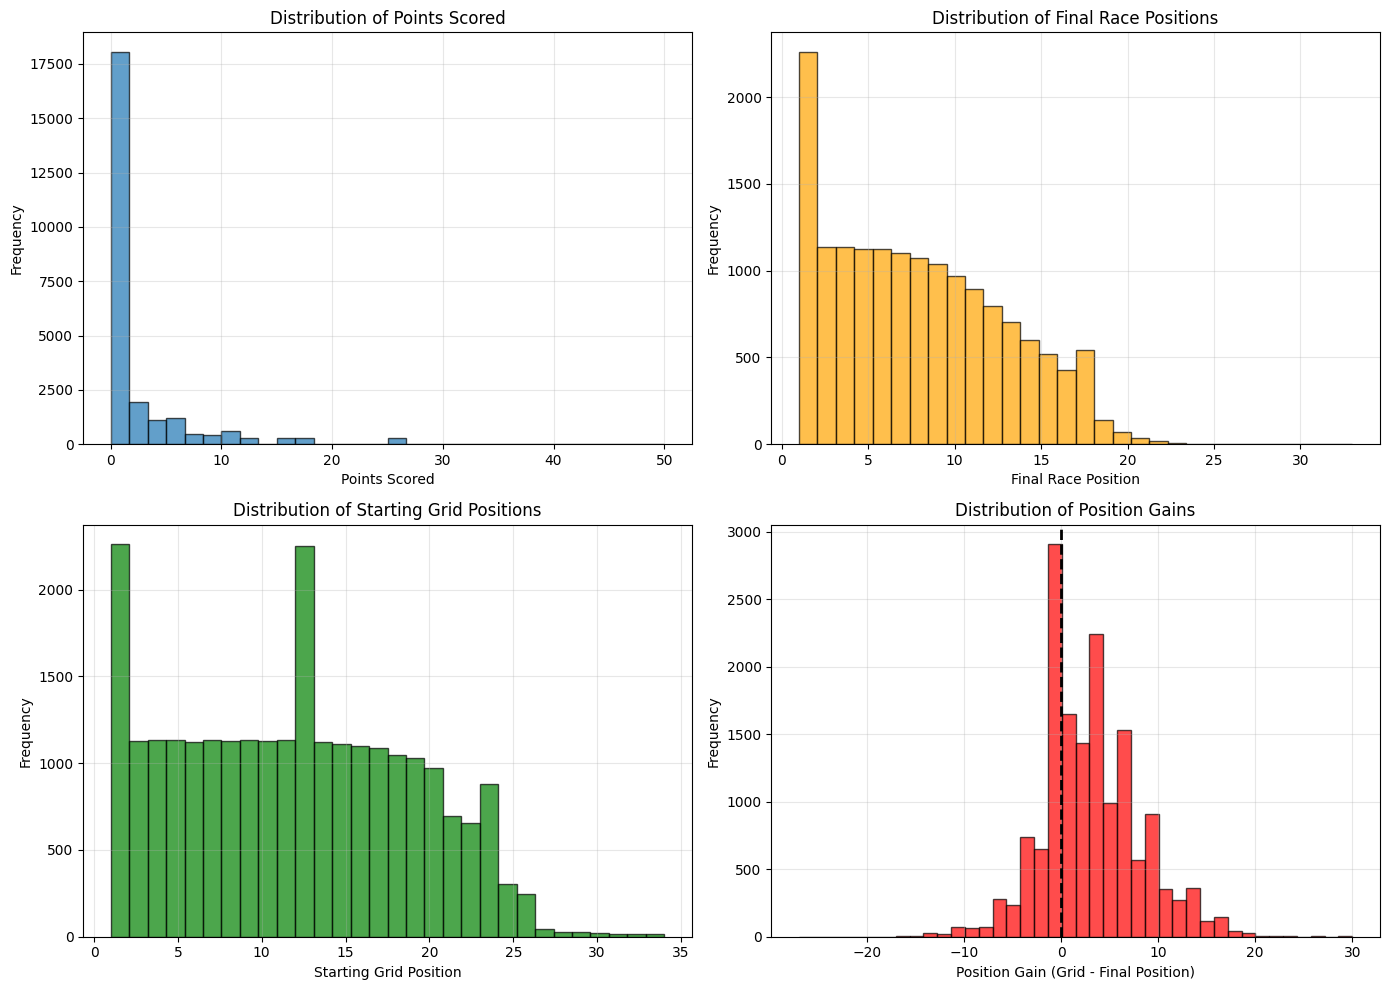

In [31]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].hist(df['points'].dropna(), bins=30, edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Points Scored')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of Points Scored')
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].hist(df['position'].dropna(), bins=30, edgecolor='black', alpha=0.7, color='orange')
axes[0, 1].set_xlabel('Final Race Position')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Distribution of Final Race Positions')
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].hist(df['grid'].dropna(), bins=30, edgecolor='black', alpha=0.7, color='green')
axes[1, 0].set_xlabel('Starting Grid Position')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Distribution of Starting Grid Positions')
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].hist(df['position_gain'].dropna(), bins=40, edgecolor='black', alpha=0.7, color='red')
axes[1, 1].set_xlabel('Position Gain (Grid - Final Position)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Distribution of Position Gains')
axes[1, 1].axvline(x=0, color='black', linestyle='--', linewidth=2)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Points distribution is highly skewed with many zeros, indicating class imbalance. Position distributions show expected patterns with more drivers finishing in lower positions.

**Q:** What does the position gain distribution tell us about race dynamics?


### Correlation Analysis


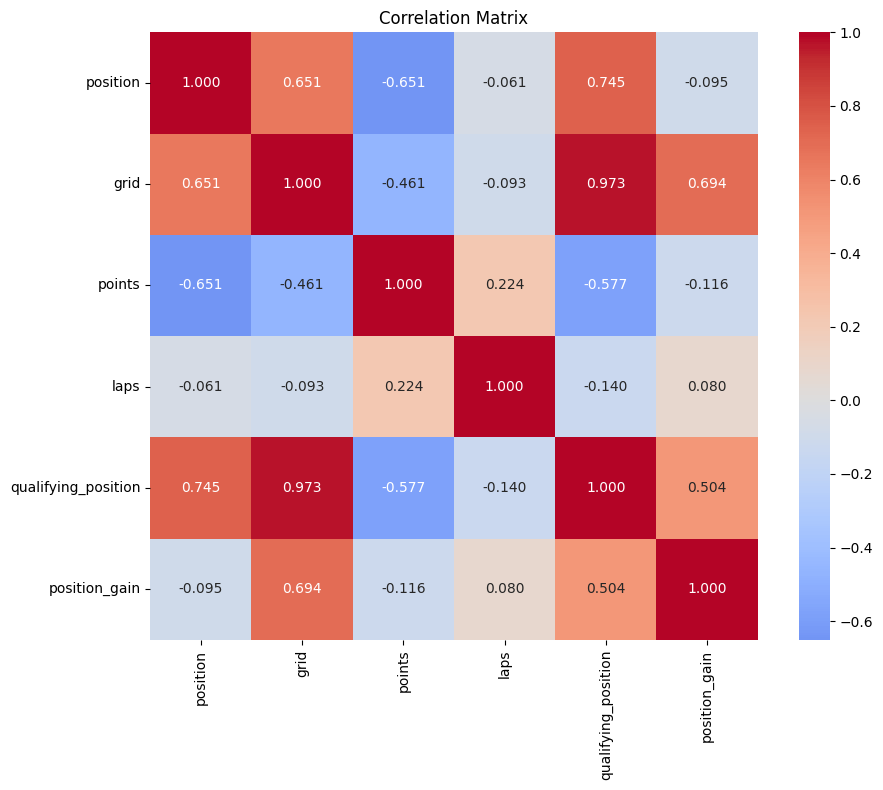

Grid vs Position: 0.651
Qualifying vs Position: 0.745
Points vs Position: -0.651


In [32]:
num_cols = ['position', 'grid', 'points', 'laps', 'qualifying_position', 'position_gain']
num_cols = [c for c in num_cols if c in df.columns]

corr = df[num_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt='.3f', cmap='coolwarm', center=0, square=True)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

print(f"Grid vs Position: {corr.loc['grid', 'position']:.3f}")
if 'qualifying_position' in corr.columns:
    print(f"Qualifying vs Position: {corr.loc['qualifying_position', 'position']:.3f}")
print(f"Points vs Position: {corr.loc['points', 'position']:.3f}")


Strong correlation between starting position and final position suggests qualifying performance is a key predictor of race outcomes.

**Q:** Why might qualifying position have a stronger correlation than grid position?

The exploratory analysis helps show why certain features were selected for the modeling. The strong correlations between qualifying positon and final race position being approximately 0.74 shows that starting performance is the strongest predictor of finishing result. Because qualifying positon reflects the raw pace without any other randomness, it also serves as a more reliable variable than grid position.

EDA also shows clear and meaningful differences across circuits. Some circuits consistently produce larger average position gains (e.g., Detroit, Zolder), while other circuits show less movement, although many are similar to Detroit and Zolder. This indicates that circuitRef captures real variation in overtaking difficulty and race dynamics, so it is also an important categorical feature. Additionally, the constructor effects also showed similarly strong variation. Teams differ widely in competitive performance, so constructorId was also kept as a categorical feature even though high dimensionality was created when one-hot encoded. This aligns with the coefficients observed in the baseline model.

Lastly, because the points distribution is highly imbalanced, with 67.5% of finishes resulting in zero points scored, the EDA suggests that we treat points as a separate binary classification problem. Therefore, we created the scored_points feature for logistic regression. Overall, EDA showed which variables contain meaningful predictive signals and this directly played a role in the feature engineering and baseline model choices used in the following sections.

### Qualifying vs Race Performance


Correlation: 0.744


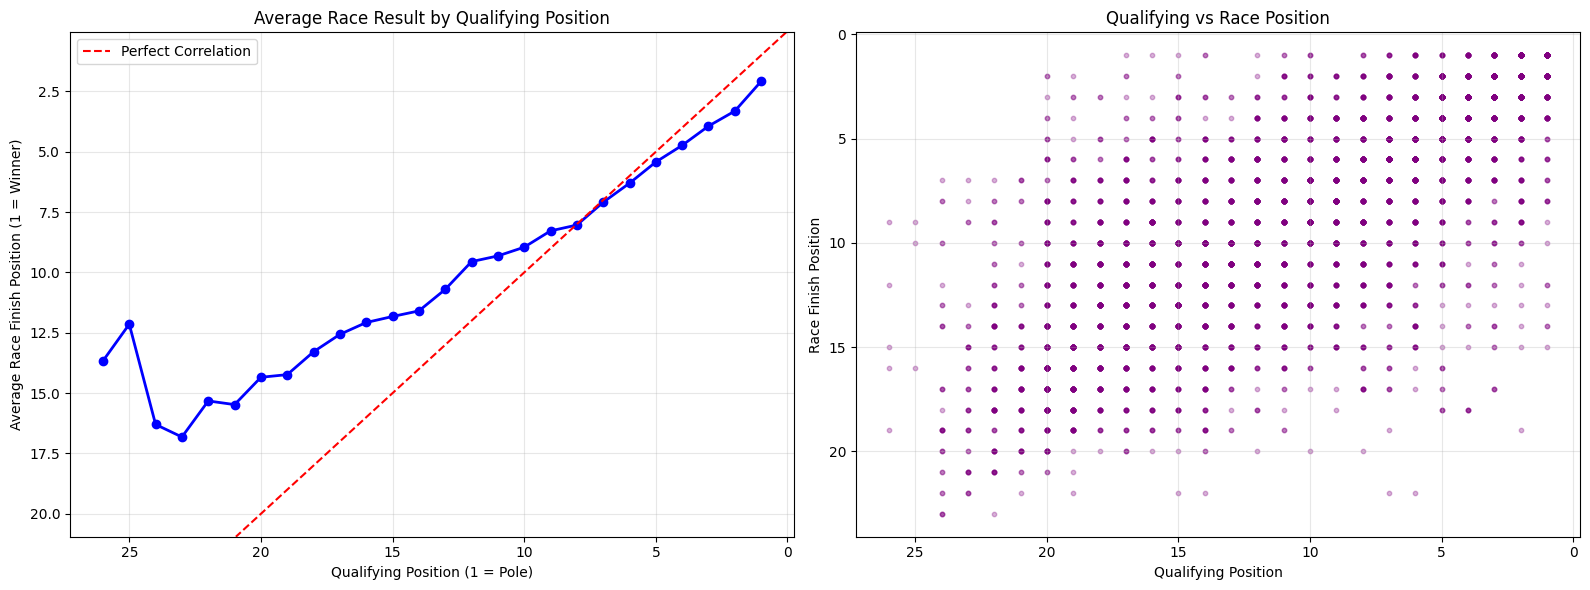

In [22]:
tmp = pd.merge(results, qualifying[['raceId', 'driverId', 'position']], 
               on=['raceId', 'driverId'], how='inner')
tmp = tmp.rename(columns={'position_x': 'race_position', 'position_y': 'qualifying_position'})

for col in ['race_position', 'qualifying_position']:
    tmp[col] = pd.to_numeric(tmp[col], errors='coerce')

tmp = tmp.dropna(subset=['race_position', 'qualifying_position'])
tmp = tmp[(tmp['race_position'] > 0) & (tmp['qualifying_position'] > 0)]

correlation = tmp[['qualifying_position', 'race_position']].corr()
print(f"Correlation: {correlation.loc['qualifying_position', 'race_position']:.3f}")

avg_finish = tmp.groupby('qualifying_position')['race_position'].mean().reset_index()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.plot(avg_finish['qualifying_position'], avg_finish['race_position'], 
         marker='o', linewidth=2, markersize=6, color='blue')
ax1.set_xlabel("Qualifying Position (1 = Pole)")
ax1.set_ylabel("Average Race Finish Position (1 = Winner)")
ax1.set_title("Average Race Result by Qualifying Position")
ax1.invert_xaxis()
ax1.invert_yaxis()
ax1.grid(True, alpha=0.3)
ax1.axline((1, 1), (20, 20), color='red', linestyle='--', label='Perfect Correlation')
ax1.legend()

scatter_data = tmp.sample(min(5000, len(tmp)))
ax2.scatter(scatter_data['qualifying_position'], scatter_data['race_position'], 
           alpha=0.3, s=10, color='purple')
ax2.set_xlabel("Qualifying Position")
ax2.set_ylabel("Race Finish Position")
ax2.set_title("Qualifying vs Race Position")
ax2.invert_xaxis()
ax2.invert_yaxis()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### Circuit Analysis


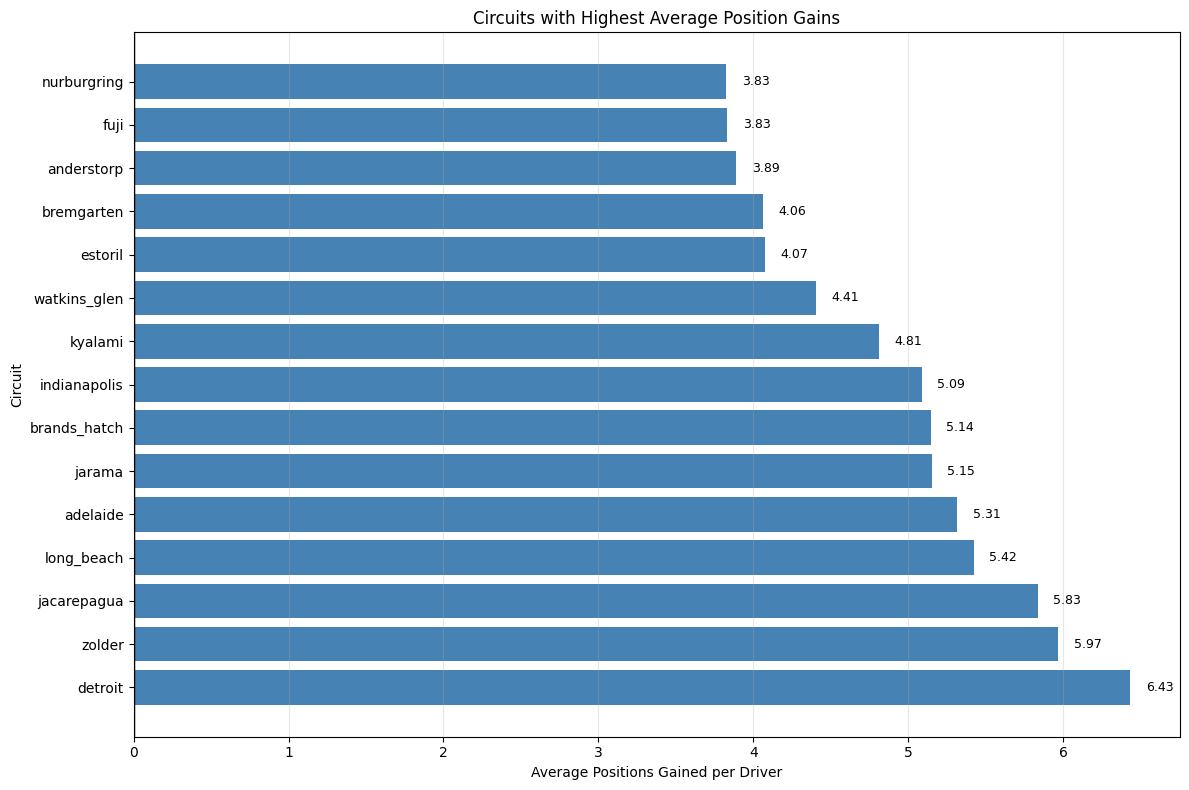

In [23]:
tmp = df.dropna(subset=['grid', 'position', 'circuitRef'])
tmp = tmp[(tmp['grid'] > 0) & (tmp['position'] > 0)]
tmp['pos_gain'] = tmp['grid'] - tmp['position']

circuit_gain = tmp.groupby('circuitRef')['pos_gain'].agg(['mean', 'count']).reset_index()
circuit_gain = circuit_gain[circuit_gain['count'] >= 50].sort_values('mean', ascending=False).head(15)

fig, ax = plt.subplots(figsize=(12, 8))
ax.barh(circuit_gain['circuitRef'], circuit_gain['mean'], color='steelblue')
ax.set_xlabel("Average Positions Gained per Driver")
ax.set_ylabel("Circuit")
ax.set_title("Circuits with Highest Average Position Gains")
ax.axvline(x=0, color='black', linestyle='-', linewidth=1)
ax.grid(True, axis='x', alpha=0.3)

for i, (idx, row) in enumerate(circuit_gain.iterrows()):
    ax.text(row['mean'] + 0.1, i, f"{row['mean']:.2f}", va='center', fontsize=9)

plt.tight_layout()
plt.show()


### Points Distribution


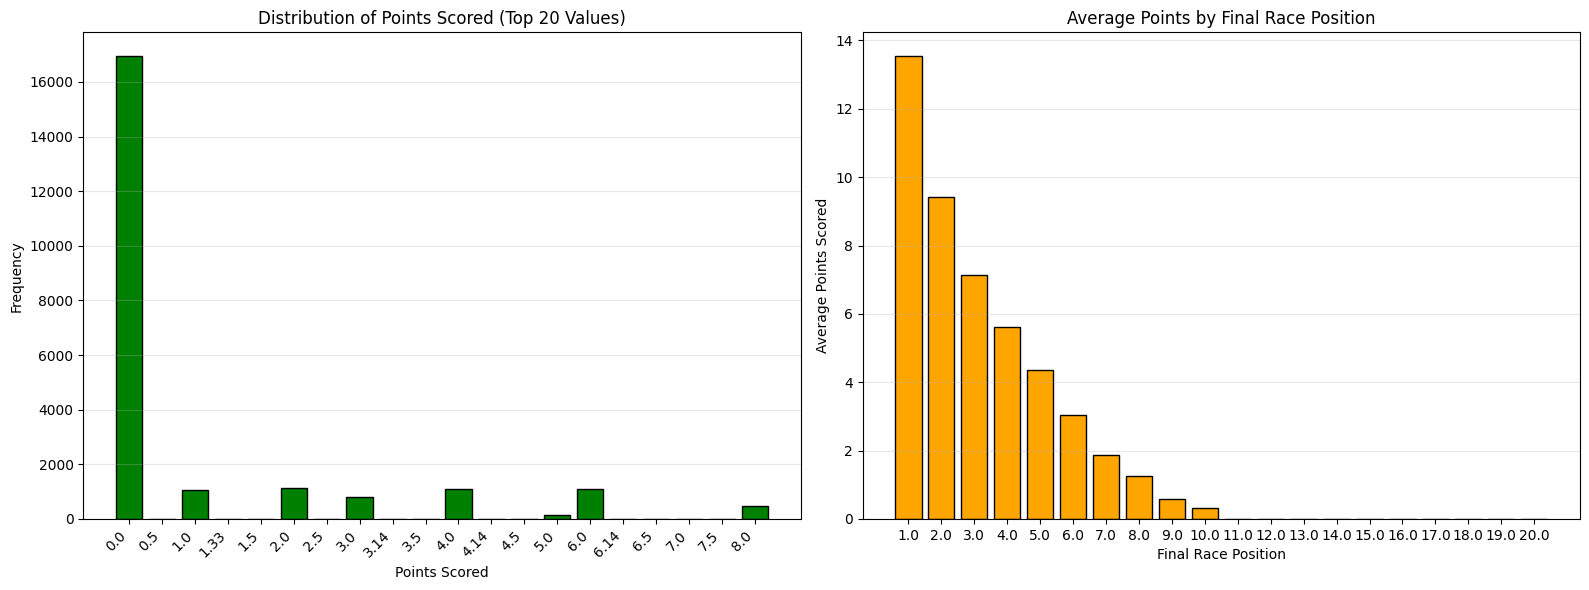

Zero points: 16,965 (67.5%)
Non-zero points: 8,156 (32.5%)


In [24]:
points_analysis = df['points'].value_counts().sort_index()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

top_points = points_analysis.head(20)
ax1.bar(range(len(top_points)), top_points.values, color='green', edgecolor='black')
ax1.set_xticks(range(len(top_points)))
ax1.set_xticklabels(top_points.index, rotation=45, ha='right')
ax1.set_xlabel("Points Scored")
ax1.set_ylabel("Frequency")
ax1.set_title("Distribution of Points Scored (Top 20 Values)")
ax1.grid(True, axis='y', alpha=0.3)

position_points = df.groupby('position')['points'].mean().head(20)
ax2.bar(range(len(position_points)), position_points.values, color='orange', edgecolor='black')
ax2.set_xticks(range(len(position_points)))
ax2.set_xticklabels(position_points.index)
ax2.set_xlabel("Final Race Position")
ax2.set_ylabel("Average Points Scored")
ax2.set_title("Average Points by Final Race Position")
ax2.grid(True, axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

zero_points = (df['points'] == 0).sum()
non_zero_points = (df['points'] > 0).sum()
print(f"Zero points: {zero_points:,} ({zero_points/len(df)*100:.1f}%)")
print(f"Non-zero points: {non_zero_points:,} ({non_zero_points/len(df)*100:.1f}%)")


## 3 - Insights for Modeling Phase

**Quick Takeaways**:
- Qualifying position has 0.743 correlation with final position - strongest single predictor
- Grid position can be NaN (58.6% missing qualifying data) but less common than other missing features
- Points distribution is highly imbalanced - 67.5% zero points, 32.5% scored points
- Circuit characteristics show significant variation (5-7 position gains vs minimal gains)
- Position gains are normally distributed around 0, but vary by circuit type
- Constructor features show high importance but create 238 features after one-hot encoding

**Modeling Implications**:
- Use grid/qualifying position as primary feature (handle missing data)
- Address class imbalance for points (class weights or two-stage approach)
- Include circuit as categorical (many categories, may need regularization)
- Constructor features important but high dimensionality - consider regularization
- Position gains show non-linear patterns - consider interaction terms


## 4 - Baseline Models

Our EDA showed that the relationship between starting position and finishing position is largely monotonic and approximately linear for most of the field, which was expected. Since grid and qualifying positions have strong correlations with race outcomes, the linear regression provides a solid baseline for these trends.

Similarly, the distribution of points is heavily imbalanced, so the prediction of "scored vs. did not score" was made a natural binary classification task. A logistic regression is appropriate because it is simple and helps us examine how the categorical constructor and circuit effects shift probabilities. It also helps validate the importance of features identified during EDA.

Two baseline models:
1. Linear Regression - predict final race position
2. Logistic Regression - predict points/no-points

**Why baselines**: Linear relationships evident, interpretable, establish benchmarks.

**Features**: grid position, circuitRef, constructorId

**Model 1**: `position ~ grid + circuitRef + constructorId`  
**Model 2**: `points_binary ~ grid + circuitRef + constructorId`


In [33]:
df_modeling = df.dropna(subset=['position', 'grid', 'points'])
df_modeling['scored_points'] = (df_modeling['points'] > 0).astype(int)

features_to_use = ['grid', 'circuitRef', 'constructorId']
X = df_modeling[features_to_use].copy()
X_encoded = pd.get_dummies(X, columns=['circuitRef', 'constructorId'], drop_first=True)

y_position = df_modeling['position']
y_points_binary = df_modeling['scored_points']

print(f"Dataset: {X_encoded.shape[0]:,} samples, {X_encoded.shape[1]} features")
print(f"Points: {y_points_binary.sum():,} scored ({(y_points_binary.sum()/len(y_points_binary)*100):.1f}%), {(len(y_points_binary) - y_points_binary.sum()):,} no points ({((len(y_points_binary) - y_points_binary.sum())/len(y_points_binary)*100):.1f}%)")


Dataset: 15,746 samples, 238 features
Points: 8,140 scored (51.7%), 7,606 no points (48.3%)


### Linear Regression for Race Position

The linear regression model captures more than half of the variance in finishing position (R² = 0.557), but the residual plot shows clear patterns of heteroskedasticity and nonlinearity. The residuals increase in magnitude for positions in the middle, suggesting that the true relationship between starting position and final position is not strictly linear. Additionally, the constructor and circuit effects likely interact with the starting grid position in nonlinear ways that a linear model cannot truly represent. That said, given these limitations, we will need a more flexible final model to capture nonlinear interactions and complex feature relationships.

Test RMSE: 3.196
Test MAE: 2.483
Test R²: 0.557

Top features:
               feature       coef
170  constructorId_116  11.550267
199  constructorId_160  11.249492
197  constructorId_158   8.851042
161  constructorId_107   8.657399
169  constructorId_115   7.241744
200  constructorId_164   6.642612
229  constructorId_206   6.105331
201  constructorId_166   6.098367
230  constructorId_207   5.860880
228  constructorId_205   5.611685


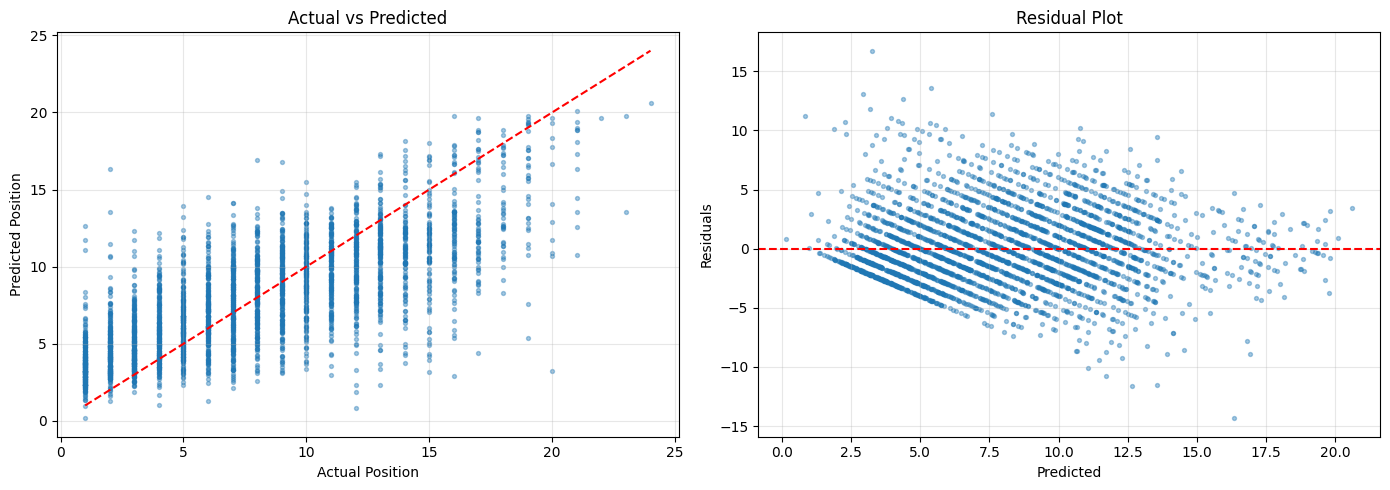

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_position, test_size=0.2, random_state=42)

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred_test = lr.predict(X_test)

test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
test_mae = mean_absolute_error(y_test, y_pred_test)
test_r2 = r2_score(y_test, y_pred_test)

print(f"Test RMSE: {test_rmse:.3f}")
print(f"Test MAE: {test_mae:.3f}")
print(f"Test R²: {test_r2:.3f}")

feat_imp = pd.DataFrame({
    'feature': X_encoded.columns,
    'coef': np.abs(lr.coef_)
}).sort_values('coef', ascending=False)
print(f"\nTop features:\n{feat_imp.head(10)}")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].scatter(y_test, y_pred_test, alpha=0.4, s=8)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=1.5)
axes[0].set_xlabel('Actual Position')
axes[0].set_ylabel('Predicted Position')
axes[0].set_title('Actual vs Predicted')
axes[0].grid(True, alpha=0.3)

residuals = y_test - y_pred_test
axes[1].scatter(y_pred_test, residuals, alpha=0.4, s=8)
axes[1].axhline(0, color='r', linestyle='--')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Residuals')
axes[1].set_title('Residual Plot')
axes[1].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


### Logistic Regression for Points Classification


Test Accuracy: 0.793

Classification Report:
               precision    recall  f1-score   support

    No Points       0.78      0.80      0.79      1522
Scored Points       0.81      0.79      0.80      1628

     accuracy                           0.79      3150
    macro avg       0.79      0.79      0.79      3150
 weighted avg       0.79      0.79      0.79      3150


Top features:
               feature      coef
230  constructorId_207  2.017035
228  constructorId_205  1.811773
229  constructorId_206  1.732878
83     constructorId_8  1.628019
232  constructorId_209  1.566726
180  constructorId_131  1.547298
200  constructorId_164  1.534192
126   constructorId_54  1.520979
110   constructorId_35  1.468427
201  constructorId_166  1.390767


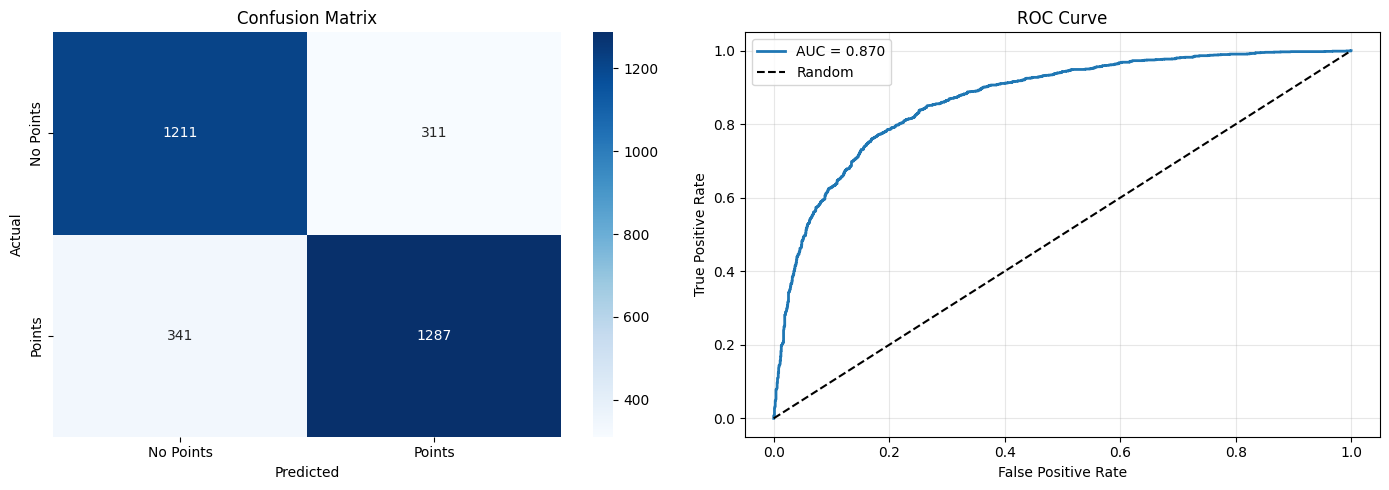

In [35]:
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y_points_binary, test_size=0.2, random_state=42, stratify=y_points_binary
)

lr_clf = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
lr_clf.fit(X_train, y_train)

y_pred = lr_clf.predict(X_test)
y_proba = lr_clf.predict_proba(X_test)[:, 1]

test_acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_acc:.3f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['No Points', 'Scored Points']))

feat_imp_clf = pd.DataFrame({
    'feature': X_encoded.columns,
    'coef': np.abs(lr_clf.coef_[0])
}).sort_values('coef', ascending=False)
print(f"\nTop features:\n{feat_imp_clf.head(10)}")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['No Points', 'Points'], yticklabels=['No Points', 'Points'])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_title('Confusion Matrix')

fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
axes[1].plot(fpr, tpr, lw=2, label=f'AUC = {roc_auc:.3f}')
axes[1].plot([0, 1], [0, 1], 'k--', label='Random')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


### Final Model Pipeline

In [37]:
X = X_encoded
y = y_position
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

gbr = GradientBoostingRegressor(random_state=42)
gbr.fit(X_train, y_train)

y_pred_test = gbr.predict(X_test)

gbr_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
gbr_mae = mean_absolute_error(y_test, y_pred_test)
gbr_r2 = r2_score(y_test, y_pred_test)

print("Gradient Boosting Results:")
print(f"RMSE: {gbr_rmse:.3f}")
print(f"MAE: {gbr_mae:.3f}")
print(f"R²: {gbr_r2:.3f}")

Gradient Boosting Results:
RMSE: 3.237
MAE: 2.512
R²: 0.545


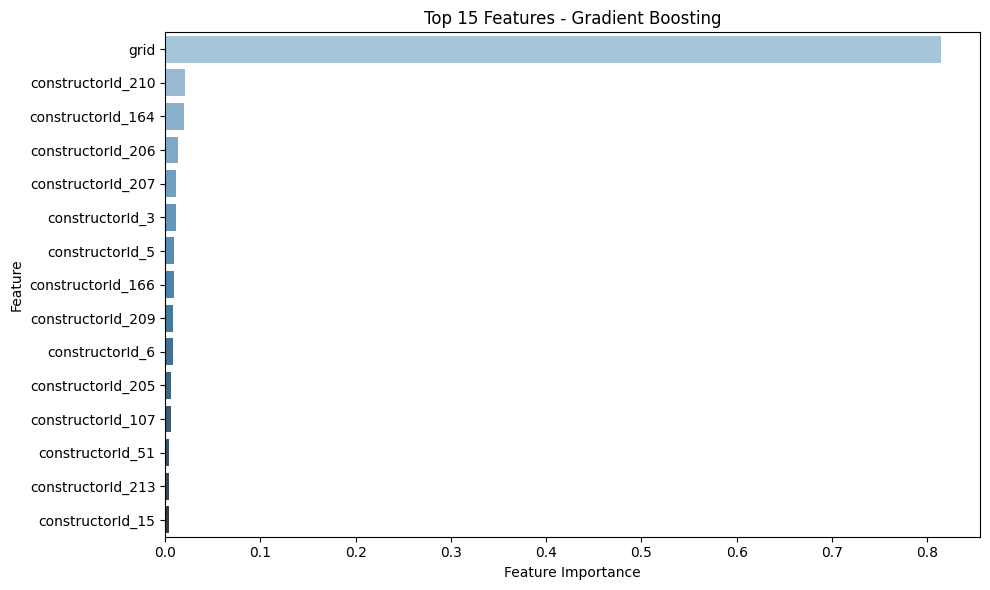

In [38]:
feat_imp = pd.DataFrame({'feature': X.columns, 'importance': gbr.feature_importances_}).sort_values('importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(data=feat_imp.head(15), x='importance', y='feature', palette='Blues_d')
plt.title("Top 15 Features - Gradient Boosting")
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

### Model Summary

**Linear Regression**: Baseline for position prediction
- RMSE: 3.196
- MAE: 2.483
- R²: 0.557

**Logistic Regression**: Baseline for points classification
- Accuracy: 0.793
- AUC: 0.870

Both models validate EDA findings - qualifying/grid position is most important feature for both finishing position and point scoring.

**Gradient Boosting Regressor**: Captures nonlinear patterns found in EDA
- RMSE: 3.237
- MAE: 2.512
- R²: 0.545

The performance of this model is similar to that of the linear regression model, performing only slightly worse in variance explained. We find that grid position alone accounts for approximately 80% of total feature importance, and the constructor effects make up the small rest. CircuitRef plays a small role compared to the car/team performance and starting positions, even though they influence overtaking patterns. This final model confirms that although there are nonlinear components in the data, most of the  predictive power comes from initial race conditions and team strength. Overall, with the baseline and final models combined, we know that the distribution of final race outcomes in F1 is dominated by initial conditions like qualifying/grid and car performance, with diminishing marginal returns when additional features are added.